In [1]:
import src as typy
from joblib import Parallel, delayed
from multiprocessing import cpu_count
import os
import numpy as np
import matplotlib.pyplot as plt
import json
from scipy.ndimage import gaussian_filter1d
import pandas as pd

In [2]:
plt.style.use('seaborn-v0_8-bright')
from cycler import cycler
color=['blue','green','red','orange','cyan','darkviolet','brown','deeppink','lime']
default_cycler = (cycler(color=color))
plt.rc('axes', prop_cycle=default_cycler)

In [3]:
outdir= "./Results"
sigmas = [0.0057,0.009,0.02]
# sigmas = [0.0057]

In [4]:
data_array = [typy.reads.read_epc(path=f"{outdir}/{i}") for i in sigmas]

In [5]:
models = []
for data in data_array:
    meta,e_k,e_kq,ph,g_kq = data
    model = typy.epc.model(e_k,e_kq,ph=np.zeros(shape=(meta.nph,meta.nq)),g=g_kq)
    models.append(model)
nph = meta['nph']
nq = meta['nq']
sym = meta['sym']
sym_label = meta['sym_label']

self_data = []
for model in models:
    selfen_matrix  = model.calculate('selfen')
    selfen = -np.array(selfen_matrix).T.real
    selfen_limit  = model.calculate('selfen_limit')
    limit =  -np.rollaxis(np.array(selfen_limit),0,3).real
    self_data.append([selfen,limit])

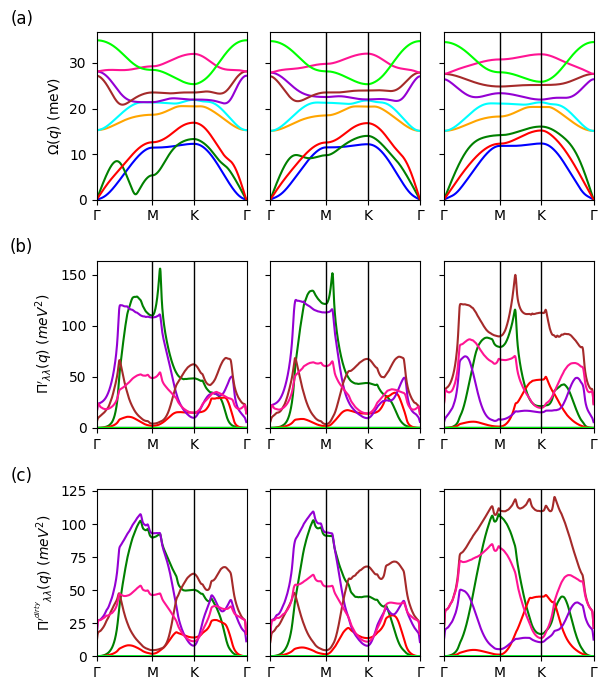

In [29]:
fig, axs = plt.subplots(3, len(models),figsize=(6,7), sharey='row')
for j,data in enumerate(data_array):
    meta,e_k,e_kq,ph,g_kq = data
    #Phonon
    for i in range(model.nph):
        axs[0][j].plot(ph[i],label=i,lw=1.5,color=color[i])
    axs[0][j].set_xlim(0,meta['nq'])
    axs[0][j].set_ylim(0)
    if j==0:
        axs[0][j].set_ylabel(r"$\Omega(q)$ (meV)")
    axs[0][j].set_xticks(meta['sym'],meta['sym_label'])
    for i in sym[1:-1]:
        axs[0][j].axvline(i, c='black' ,lw=1)
    axs[0][0].set_title('(a)', x=-0.5,y=1)

for j,model in enumerate(models):
    for i in range(9):
        axs[1][j].plot(gaussian_filter1d(self_data[j][0][i],2),label=i,lw=1.5,color=color[i])
    axs[1][j].set_ylim(0)

    axs[1][j].set_xlim(0,model.nq)
    if j==0:
        axs[1][j].set_ylabel(r"${\Pi^{\prime}}_{\lambda\lambda}(q)$ (${meV}^{2}$)")
    axs[1][j].set_xticks(sym,["Γ","M","K","Γ"])
    for i in sym[1:-1]:
        axs[1][j].axvline(i,c='black'  ,lw=1)
    axs[1][j].set_xlim(0,model.nq)
    axs[1][0].set_title('(b)', x=-0.5,y=1)

for j,model in enumerate(models):
    for i in range(9):
        axs[2][j].plot(gaussian_filter1d(self_data[j][1][i][i],2),label=i,lw=1.5,color=color[i])
    axs[2][j].set_xlim(0,model.nq)
    if j==0:
        axs[2][j].set_ylabel(r"${\Pi^{\prime^{dirty}}}_{\lambda\lambda}(q)$ (${meV}^{2}$)")
    # else:
        # axs[j].set_yticks([])
    # axs[2][j].set_ylim(0,)
    axs[2][j].set_xticks(sym,["Γ","M","K","Γ"])
    for i in sym[1:-1]:
        axs[2][j].axvline(i, c='black' ,lw=1)
    # axs[j].set_ylim(0,160)
    axs[2][j].set_xlim(0,model.nq)
    axs[2][0].set_title('(c)', x=-0.5,y=1)

plt.ylim(0,)
plt.tight_layout()
plt.savefig("./Plots/multi_plot.pdf")
plt.show()

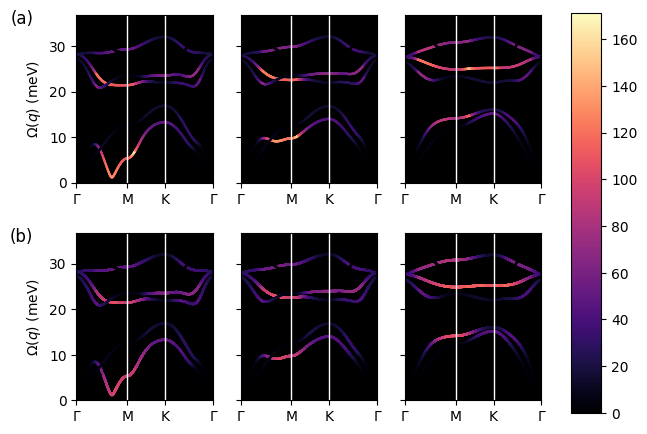

In [99]:
fig, axs = plt.subplots(2, len(models),figsize=(6,5), sharey='row')
path_tile = np.tile(np.arange(nq),9)
selfen_tile = np.zeros(shape=(len(models),nph,nq))

for j,model in enumerate(models):
    for i in range(model.nph):
        selfen_tile[j][i] = self_data[j][0][i].flatten()
min_, max_ = selfen_tile.min(), selfen_tile.max()

for j,data in enumerate(data_array):
    meta,e_k,e_kq,ph,g_kq = data 
    for i in range(nph):    
        ph_tile = ph.flatten()
        #Phonon
        # im = axs[0][j].scatter(path_tile,eph_tile,c=selfen_tile[j],vmin=min_, vmax=max_,s=1,cmap='magma')
    im=axs[0][j].scatter(path_tile,ph_tile,c=selfen_tile[j],vmin=min_, vmax=max_,s=0.5,cmap='magma')
    axs[0][j].set_xlim(0,model.nq)
    axs[0][j].set_ylim(0)
    if j==0:
        axs[0][j].set_ylabel(r"$\Omega(q)$ (meV)")
    axs[0][j].set_xticks(sym,["Γ","M","K","Γ"])
    for i in sym[1:-1]:
        axs[0][j].axvline(i, c='white' ,lw=1)
    axs[0][0].set_title('(a)', x=-0.4,y=0.9)


for j,model in enumerate(models):
    for i in range(model.nph):
        selfen_tile[j][i] = self_data[j][1][i][i].flatten()
# min_, max_ = selfen_tile.min(), selfen_tile.max()


for j,data in enumerate(data_array):
    meta,e_k,e_kq,ph,g_kq = data 
    for i in range(nph):    
        ph_tile = ph.flatten()
        axs[1][j].scatter(path_tile,ph_tile,c=selfen_tile[j],vmin=min_, vmax=max_,s=0.5,cmap='magma')
    axs[1][j].set_ylim(0)

    axs[1][j].set_xlim(0,model.nq)
    if j==0:
        axs[1][j].set_ylabel(r"$\Omega(q)$ (meV)")
    axs[1][j].set_xticks(sym,["Γ","M","K","Γ"])
    for i in sym[1:-1]:
        axs[1][j].axvline(i,c='white'  ,lw=1)
    axs[1][j].set_xlim(0,model.nq)
    axs[1][0].set_title('(b)', x=-0.4,y=0.9)

for i in range(axs.shape[0]):
    for j in range(axs.shape[1]):
        axs[i][j].set_facecolor("black")

cbar_ax = fig.add_axes([0.95, 0.085, 0.05, 0.8])

fig.subplots_adjust(wspace=0.2, hspace=0.3, right=0.9)
fig.colorbar(im, cax=cbar_ax)

plt.ylim(0,)
# plt.tight_layout()
plt.savefig("./Plots/spectrum.png", bbox_inches='tight',dpi=300)
plt.show()